<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-libraries" data-toc-modified-id="Load-the-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the libraries</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Modelling:-xgb" data-toc-modified-id="Modelling:-xgb-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling: xgb</a></span><ul class="toc-item"><li><span><a href="#default" data-toc-modified-id="default-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>default</a></span></li><li><span><a href="#Trial-1" data-toc-modified-id="Trial-1-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Trial 1</a></span></li><li><span><a href="#Few-Trials" data-toc-modified-id="Few-Trials-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Few Trials</a></span></li><li><span><a href="#Hyperparameter-optimization" data-toc-modified-id="Hyperparameter-optimization-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Hyperparameter optimization</a></span><ul class="toc-item"><li><span><a href="#HPO-using-RandomizedSearchCV" data-toc-modified-id="HPO-using-RandomizedSearchCV-4.4.1"><span class="toc-item-num">4.4.1&nbsp;&nbsp;</span>HPO using RandomizedSearchCV</a></span></li></ul></li></ul></li></ul></div>

# Load the libraries

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.plotting.backend = "matplotlib"
pd.set_option('max_columns',100)

import time,os,json
time_start_notebook = time.time()
home = os.path.expanduser('~')
SEED=100

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sklearn
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

import joblib
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier

[(x.__name__,x.__version__) for x in [np,pd,sns,sklearn,lgb]]

[('numpy', '1.18.4'),
 ('pandas', '1.1.0'),
 ('seaborn', '0.10.1'),
 ('sklearn', '0.23.1'),
 ('lightgbm', '2.3.1')]

In [2]:
def print_scores(ytest,ypreds):
    # for auc score we need to binarize
    labels = [0, 1, 2, 3]
    ytest_bin = label_binarize(ytest, classes=labels)
    ypreds_bin = label_binarize(ypreds, classes=labels)
    a = roc_auc_score(ytest_bin,ypreds_bin,
                      average='macro',multi_class='ovo')
    
    # precision recall
    p = precision_score(ytest,ypreds,average='macro')
    r = recall_score(ytest,ypreds,average='macro')
    f = f1_score(ytest,ypreds,average='macro')
    print(f'Precision: {p: .2f}')
    print(f'Recall   : {r: .2f}')
    print(f'F1-score : {f: .2f}')
    print(f'AUC      : {f: .2f}')
    

    c = classification_report(ytest, ypreds)
    print(c)

    cm = confusion_matrix(ytest,ypreds)
    names = list('ABCD')
    df_cm = pd.DataFrame(cm,index=names,columns=names)
    df_cm = df_cm.style.background_gradient()
    display(df_cm)

In [3]:
df_eval = pd.DataFrame({'Model': [],
                        'Description':[],
                        'Accuracy':[],
                        'Precision':[],
                        'Recall':[],
                        'F1':[],
                        'AUC': []
                    })

# Load the data

In [4]:
df_raw = pd.read_csv('../data/raw/train.csv')
print(df_raw.shape)

df_raw.head(2).append(df_raw.tail(2))

(8068, 11)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6,B
8067,461879,Male,Yes,37,Yes,Executive,0.0,Average,3.0,Cat_4,B


In [5]:
df = pd.read_csv('../data/processed/clean_data.csv')
print(df.shape)

df.head(2).append(df.tail(2))

(8068, 38)


,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Segmentation,Ever_Married_NA,Graduated_NA,Profession_NA,Work_Experience_NA,Family_Size_NA,Var_1_NA,Age_cat,Family_Size_cat,Work_Experience_cat,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,gen_mar,gen_grad,gen_spend,grad_spend,grad_spend_gen
0,0,0,22,0,1.0,0,4.0,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,38,1,3.0,1,3.0,0,0,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,3,3,4,4,13
8066,1,0,27,1,1.0,0,4.0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,3,1,1,10
8067,0,1,37,1,0.0,1,3.0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,2,3,4,4


# Train test split

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
target = 'Segmentation'

df_Xtrain_orig, df_Xtest, ser_ytrain_orig, ser_ytest = train_test_split(
    df.drop(target,axis=1), df[target],shuffle=True,
    test_size=0.2, random_state=SEED, stratify=df[target])

df_Xtrain, df_Xvalid, ser_ytrain, ser_yvalid = train_test_split(
    df_Xtrain_orig, ser_ytrain_orig,
    test_size=0.2, random_state=SEED, stratify=ser_ytrain_orig)

ytrain = ser_ytrain.to_numpy().ravel()
yvalid = ser_yvalid.to_numpy().ravel()
ytest = ser_ytest.to_numpy().ravel()

print(f"df             : {df.shape}")

print(f"\ndf_Xtrain_orig : {df_Xtrain_orig.shape}")
print(f"ser_ytrain_orig: {ser_ytrain_orig.shape}")

print(f"\ndf_Xtrain      : {df_Xtrain.shape}")
print(f"ser_ytrain     : {ser_ytrain.shape}")

print(f"\ndf_Xvalid      : {df_Xvalid.shape}")
print(f"ser_yvalid     : {ser_yvalid.shape}")

print(f"\ndf_Xtest       : {df_Xtest.shape}")
print(f"ser_ytest      : {ser_ytest.shape}")

df_Xtrain_orig.head(2)

df             : (8068, 38)

df_Xtrain_orig : (6454, 37)
ser_ytrain_orig: (6454,)

df_Xtrain      : (5163, 37)
ser_ytrain     : (5163,)

df_Xvalid      : (1291, 37)
ser_yvalid     : (1291,)

df_Xtest       : (1614, 37)
ser_ytest      : (1614,)


,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Ever_Married_NA,Graduated_NA,Profession_NA,Work_Experience_NA,Family_Size_NA,Var_1_NA,Age_cat,Family_Size_cat,Work_Experience_cat,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,gen_mar,gen_grad,gen_spend,grad_spend,grad_spend_gen
3582,0,1,27,0,2.0,0,2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0
6827,0,0,41,1,3.0,0,1.0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,1,1


In [8]:
cols_all = df_Xtrain_orig.columns.to_list()
cols_no_na = [i for i in cols_all if not i.endswith('_NA')]


cross = ['gen_mar', 'gen_grad', 'gen_spend',
         'grad_spend', 'grad_spend_gen']
cols_no_na_no_cross = [i for i in cols_no_na if i not in cross]
cols_no_na_no_cross

['Gender',
 'Ever_Married',
 'Age',
 'Graduated',
 'Work_Experience',
 'Spending_Score',
 'Family_Size',
 'Age_cat',
 'Family_Size_cat',
 'Work_Experience_cat',
 'Profession_Artist',
 'Profession_Doctor',
 'Profession_Engineer',
 'Profession_Entertainment',
 'Profession_Executive',
 'Profession_Healthcare',
 'Profession_Homemaker',
 'Profession_Lawyer',
 'Profession_Marketing',
 'Var_1_Cat_1',
 'Var_1_Cat_2',
 'Var_1_Cat_3',
 'Var_1_Cat_4',
 'Var_1_Cat_5',
 'Var_1_Cat_6',
 'Var_1_Cat_7']

In [9]:
features = cols_no_na

Xtr = df_Xtrain_orig[features]
Xtx = df_Xtest[features]
Xvd = df_Xvalid[features]

ytr = ser_ytrain_orig.to_numpy().ravel()
ytx = ser_ytest.to_numpy().ravel()
yvd = ser_yvalid.to_numpy().ravel()

# Modelling: xgb

## default

In [20]:
# time
time_start = time.time()
EVAL_METRIC = 'auc'

model_name = 'xgboost'
desc = 'default'

# model
model = xgb.XGBClassifier(random_state=SEED,n_jobs=-1)

# fit and save the model
model.fit(Xtr, ytr, eval_metric=EVAL_METRIC)


# predictions
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(model, Xtx, ytx, cv=skf)
ypreds = ypreds_cv

# auc
labels = [0, 1, 2, 3]
ytest_bin = label_binarize(ytest, classes=labels)
ypreds_bin = label_binarize(ypreds, classes=labels)
auc = roc_auc_score(ytest_bin,ypreds_bin,
                  average='macro',multi_class='ovo')

# model evaluation
average = 'macro'
row_eval = [model_name,desc, 
            accuracy_score(ytx, ypreds),
            precision_score(ytx, ypreds, average=average),
            recall_score(ytx, ypreds, average=average),
            f1_score(ytx, ypreds, average=average),
            auc
            ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)
print_scores(ytest,ypreds)

Time taken: 0 min 10 secs


,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,xgboost,default,0.498761,0.485061,0.489508,0.486528,0.661225
1,xgboost,example_1,0.503717,0.489751,0.494472,0.491265,0.664554


Precision:  0.49
Recall   :  0.49
F1-score :  0.49
AUC      :  0.49
              precision    recall  f1-score   support

           0       0.42      0.42      0.42       394
           1       0.37      0.32      0.34       372
           2       0.54      0.54      0.54       394
           3       0.62      0.68      0.64       454

    accuracy                           0.50      1614
   macro avg       0.49      0.49      0.49      1614
weighted avg       0.49      0.50      0.49      1614



,A,B,C,D
A,166,98,45,85
B,92,119,123,38
C,43,70,213,68
D,93,37,17,307


## Trial 1

In [14]:
params = {
    'max_depth': 3,  
    'min_child_weight': 1,
    'eta': 0.1,  
    'silent': 1,
    'colsample_bytree': 0.8,
    'objective': 'multi:softprob', 
    'random_state': SEED,
    'num_class': 4} 

In [15]:
# time
time_start = time.time()
EVAL_METRIC = 'auc'

model_name = 'xgboost'
desc = 'example_1'

# model
model = xgb.XGBClassifier(**params)

# fit and save the model
model.fit(Xtr, ytr, eval_metric=EVAL_METRIC)


# predictions
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(model, Xtx, ytx, cv=skf)
ypreds = ypreds_cv

# auc
labels = [0, 1, 2, 3]
ytest_bin = label_binarize(ytest, classes=labels)
ypreds_bin = label_binarize(ypreds, classes=labels)
auc = roc_auc_score(ytest_bin,ypreds_bin,
                  average='macro',multi_class='ovo')

# model evaluation
average = 'macro'
row_eval = [model_name,desc, 
            accuracy_score(ytx, ypreds),
            precision_score(ytx, ypreds, average=average),
            recall_score(ytx, ypreds, average=average),
            f1_score(ytx, ypreds, average=average),
            auc
            ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)
print_scores(ytest,ypreds)

Time taken: 0 min 11 secs


,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,xgboost,default,0.498761,0.485061,0.489508,0.486528,0.661225
1,xgboost,example_1,0.503717,0.489751,0.494472,0.491265,0.664554


Precision:  0.49
Recall   :  0.49
F1-score :  0.49
AUC      :  0.49
              precision    recall  f1-score   support

           0       0.44      0.45      0.44       394
           1       0.37      0.31      0.34       372
           2       0.53      0.54      0.54       394
           3       0.63      0.68      0.65       454

    accuracy                           0.50      1614
   macro avg       0.49      0.49      0.49      1614
weighted avg       0.50      0.50      0.50      1614



,A,B,C,D
A,176,91,50,77
B,93,116,124,39
C,43,69,214,68
D,92,40,15,307


## Few Trials

In [19]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=2,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

model.fit(Xtr,ytr)
ypreds = model.predict(Xtx)

print(confusion_matrix(ytest, ypreds))
print(accuracy_score(ytest,ypreds))

print(model.score(Xtx, ytx))
print(model.score(Xtr, ytr))

[[185  90  35  84]
 [ 99 118 117  38]
 [ 41  66 222  65]
 [ 84  34  11 325]]
0.5266418835192069
0.5266418835192069
0.6177564301208552


## Hyperparameter optimization

### HPO using RandomizedSearchCV

In [22]:
from sklearn.model_selection import (GridSearchCV,
                                     RandomizedSearchCV,
                                     StratifiedKFold)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
X = np.array(Xtr)
y = np.array(ytr)

In [23]:
params = {
  # 'min_child_weight':[1,50,100],
  # 'scale_pos_weight':[1,2,3,4],
  'max_depth': [5,6,7],
  'n_estimators':[150,200,300,400],
  'colsample_bytree':[0.7,0.8], 
  'subsample':[0.7,0.8],
  'gamma': [0.5, 1, 1.5, 2, 5],

}

model = XGBClassifier(objective='multiclass',
                    num_class=4,
                    random_state=SEED,
                    learning_rate=0.1,
                    n_jobs=-1,
                    verbose=100)

grid = RandomizedSearchCV(model,params,
                          cv=skf.split(X, y),
                          scoring='accuracy')

In [25]:
# %%time
# grid.fit(X,y)
# best_model = grid.best_estimator_
# joblib.dump(best_model, '../outputs/xgb_randomsearch_best_model.pkl')

# ## Wall time: 12min 41s

In [27]:
model_grid_random = joblib.load('../outputs/xgb_randomsearch_best_model.pkl')
model_grid_random

XGBClassifier(colsample_bytree=0.7, gamma=1.5, max_depth=5, missing=nan,
              n_estimators=150, n_jobs=-1, num_class=4,
              objective='multi:softprob', random_state=100, subsample=0.7,
              verbose=100)

In [28]:
# time
time_start = time.time()
EVAL_METRIC = 'auc'

model_name = 'xgboost'
desc = 'grid_randomsearch'

# model
model = model_grid_random

# fit and save the model
model.fit(Xtr, ytr,eval_metric=EVAL_METRIC)

# predictions
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(model, Xtx, ytx, cv=skf)
ypreds = ypreds_cv

# auc
labels = [0, 1, 2, 3]
ytest_bin = label_binarize(ytest, classes=labels)
ypreds_bin = label_binarize(ypreds, classes=labels)
auc = roc_auc_score(ytest_bin,ypreds_bin,
                  average='macro',multi_class='ovo')

# model evaluation
average = 'macro'
row_eval = [model_name,desc, 
            accuracy_score(ytx, ypreds),
            precision_score(ytx, ypreds, average=average),
            recall_score(ytx, ypreds, average=average),
            f1_score(ytx, ypreds, average=average),
            auc
            ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)
print_scores(ytest,ypreds)

Time taken: 0 min 17 secs


,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,xgboost,default,0.498761,0.485061,0.489508,0.486528,0.661225
1,xgboost,example_1,0.503717,0.489751,0.494472,0.491265,0.664554
2,xgboost,grid_randomsearch,0.506815,0.495293,0.498011,0.495879,0.666825


Precision:  0.50
Recall   :  0.50
F1-score :  0.50
AUC      :  0.50
              precision    recall  f1-score   support

           0       0.44      0.46      0.45       394
           1       0.39      0.34      0.37       372
           2       0.52      0.51      0.51       394
           3       0.62      0.68      0.65       454

    accuracy                           0.51      1614
   macro avg       0.50      0.50      0.50      1614
weighted avg       0.50      0.51      0.50      1614



,A,B,C,D
A,182,84,46,82
B,92,128,115,37
C,43,85,200,66
D,95,28,23,308


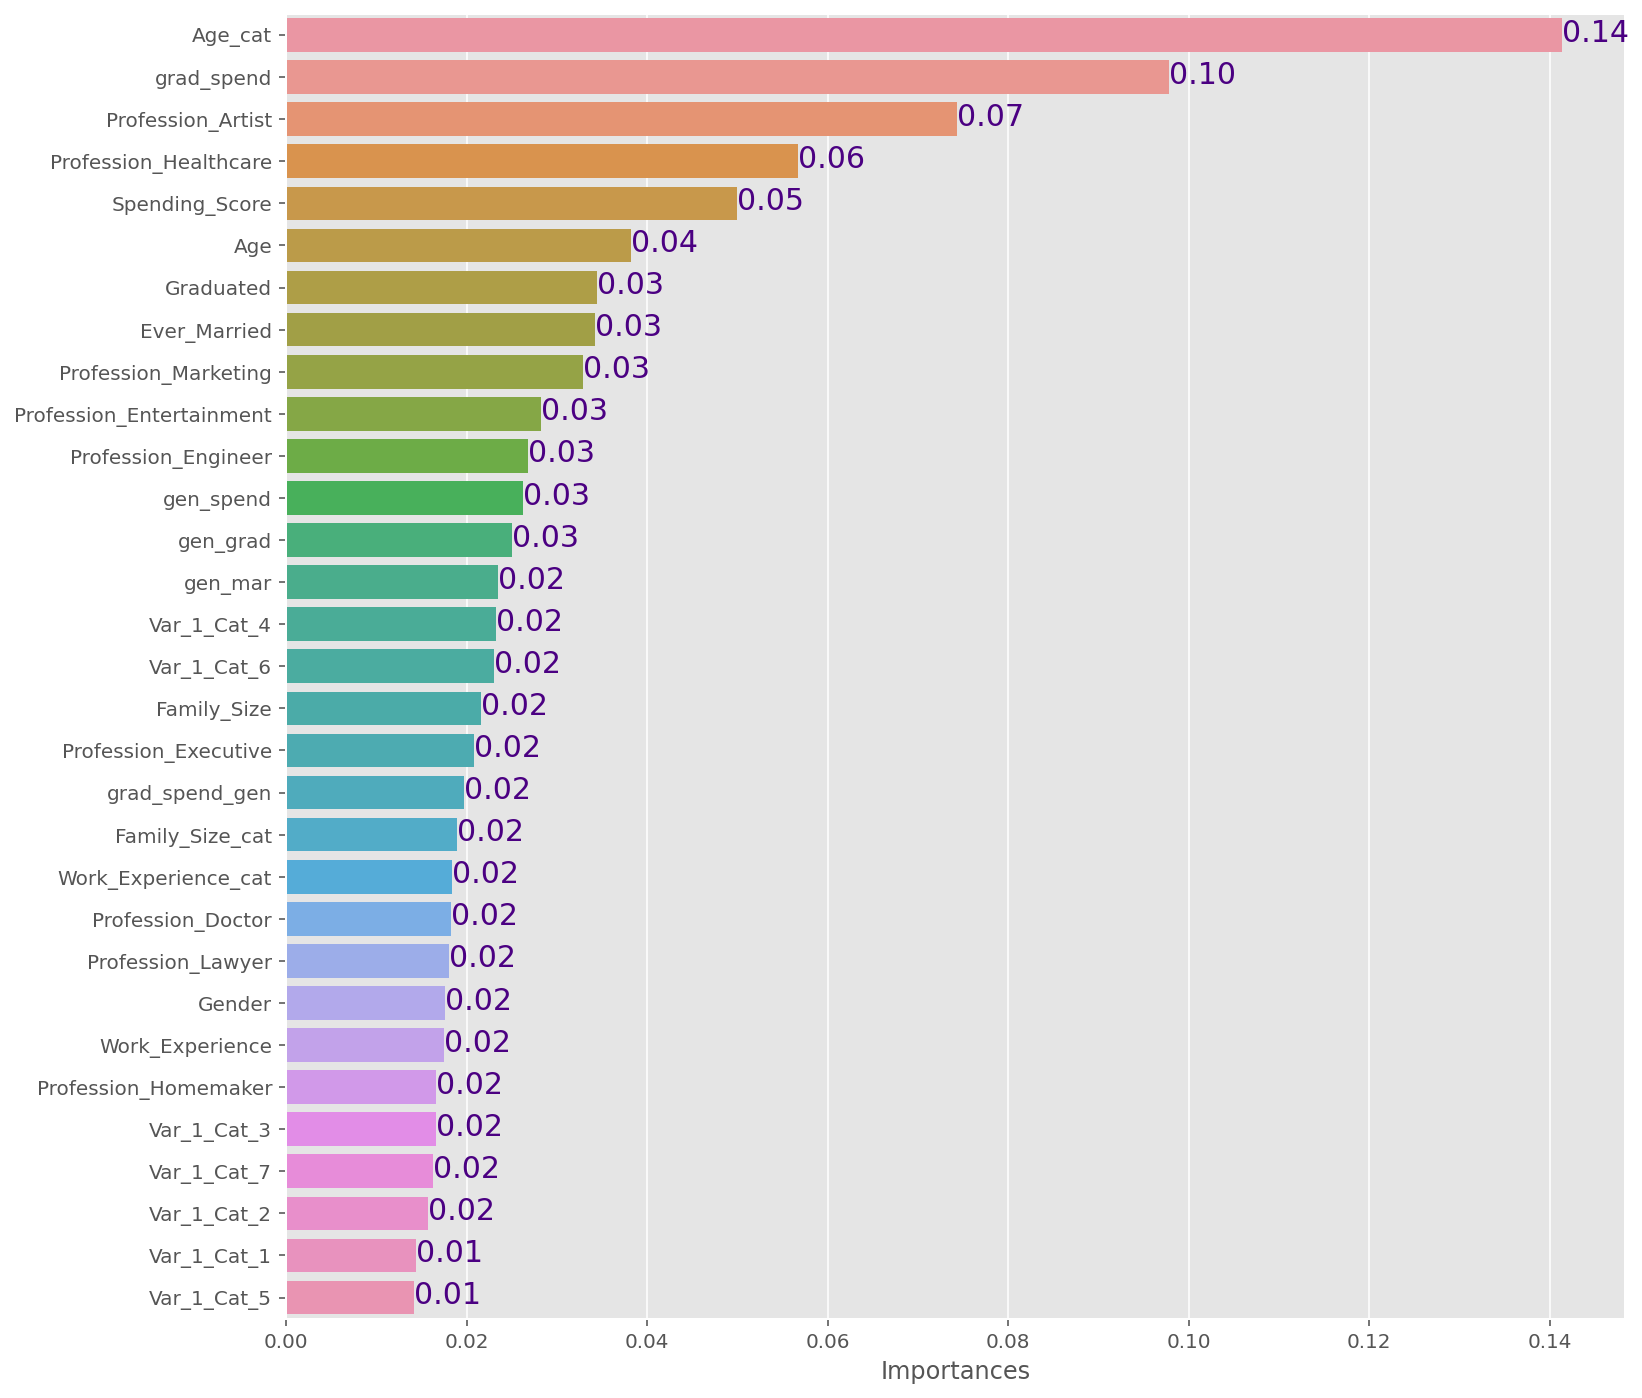

In [31]:
arr_fimp = model.feature_importances_
df_fimp = pd.DataFrame(arr_fimp,columns=['Importances'],index=features)
df_fimp = df_fimp.sort_values('Importances',ascending=False)

plt.figure(figsize=(12,12))
ax = sns.barplot(x=df_fimp.Importances, y= df_fimp.index);

for p in ax.patches:
    x = p.get_width()
    y = p.get_y()
    text = '{:.2f}'.format(p.get_width())
    ax.text(x, y,text,fontsize=15,color='indigo',va='top',ha='left')